In [8]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import sys, os
sys.path.append('code/')
from config.library_graph_definition import nodes, edges
from LicenseCompatibilityMatrix import LicenseCompatibilityMatrix

platforms = ['NPM','Rubygems','Packagist']
cm = LicenseCompatibilityMatrix(nodes, edges)

In [9]:
def determine_compatible(df_row):
    return cm.is_compatible(df_row['dep_licenses'], df_row['licenses'])

compatibility_df = []
for key in nodes.keys():
    df = pd.DataFrame({'licenses' : key, 'dep_licenses': list(nodes.keys())})
    compatibility_df.append(df)
    
compatibility_df = pd.concat(compatibility_df)
compatibility_df["compatible"] = compatibility_df.apply(determine_compatible, axis=1)

# Load packages and dependencies

In [12]:
# Load packages
packages = pd.read_csv('data/packages_ilyas.csv.gz')
packages = packages[packages.columns.difference(['dependent_projects', 'dependent_repos'])]

# Load dependencies
deps = pd.read_csv('data/dependencies_ilyas.csv.gz')
deps = deps.query('kind == "runtime"') # Focus only on runtime dependencies
deps = deps[deps.columns.difference(['kind'])]
deps["platform"] = deps.platform.astype('category')
deps["licenses"] = deps.licenses.astype('category')
deps["dep_licenses"] = deps.dep_licenses.astype('category')
deps["dependency"] = deps.dependency.astype('category')

In [13]:
# Only keep 80% of the most relied upon packages and their dependencies
dependents = (packages[packages.columns.difference(['licenses', 'first_release_date'])]
              .merge(right=deps, left_on=["platform", "name"], right_on=["platform", "dependency"])[['platform', 'name_x', 'name_y']])
dependents.rename(columns={'name_x': 'name', 'name_y': 'dependent'}, inplace=True)

ecosystem_dependents = []
for platform in platforms:
    curr_dependents = (dependents.query(f'platform == "{platform}"')
                      .groupby(['platform', 'name']).size()
                      .reset_index()
                      .rename(columns={0: 'dependent_count'})
                      .sort_values(by='dependent_count', ascending=False))
    curr_dependents = curr_dependents.iloc[0:round(len(curr_dependents)*0.80)]
    ecosystem_dependents.append(curr_dependents)

dependents = pd.concat(ecosystem_dependents, ignore_index=True, sort=False)
packages = packages.merge(right=dependents, how='inner', on=['platform', 'name'])
deps = deps.merge(right=packages[["platform", "name"]], on=["platform", "name"], how='inner')[deps.columns]
deps["name"] = deps.name.astype('category')

In [14]:
tmp = packages.groupby('platform').name.count()
amount_of_npm_packages = tmp.NPM
amount_of_packagist_packages = tmp.Packagist
amount_of_rubygems_packages = tmp.Rubygems
total_amount_of_packages = amount_of_npm_packages + amount_of_packagist_packages + amount_of_rubygems_packages
print(f'Total ampunt of packages: {total_amount_of_packages}')
print(f'Amount of NPM packages: {amount_of_npm_packages} ({round(amount_of_npm_packages/total_amount_of_packages*100, 2)}%)')
print(f'Amount of Packagist packages: {amount_of_packagist_packages} ({round(amount_of_packagist_packages/total_amount_of_packages*100, 2)}%)')
print(f'Amount of Rubygems packages: {amount_of_rubygems_packages} ({round(amount_of_rubygems_packages/total_amount_of_packages*100, 2)}%)')
print('\n')

tmp = deps.groupby('platform').name.count()
amount_of_npm_deps = tmp.NPM
amount_of_packagist_deps = tmp.Packagist
amount_of_rubygems_deps = tmp.Rubygems
total_amount_of_deps = len(deps)
print(f'Total ampunt of dependencies: {total_amount_of_deps}')
print(f'Amount of NPM dependencies: {amount_of_npm_deps} ({round(amount_of_npm_deps/total_amount_of_deps*100, 2)}%)')
print(f'Amount of Packagist dependencies: {amount_of_packagist_deps} ({round(amount_of_packagist_deps/total_amount_of_deps*100, 2)}%)')
print(f'Amount of Rubygems dependencies: {amount_of_rubygems_deps} ({round(amount_of_rubygems_deps/total_amount_of_deps*100, 2)}%)')

Total ampunt of packages: 345174
Amount of NPM packages: 286827 (83.1%)
Amount of Packagist packages: 39954 (11.58%)
Amount of Rubygems packages: 18393 (5.33%)


Total ampunt of dependencies: 1285688
Amount of NPM dependencies: 1129669 (87.86%)
Amount of Packagist dependencies: 110821 (8.62%)
Amount of Rubygems dependencies: 45198 (3.52%)


In [15]:
packages.sample()

,first_release_date,licenses,name,platform,dependent_count
56354,2012-02-29 09:14:08 UTC,MIT,architect,NPM,40


In [16]:
deps.sample()

,dep_licenses,dependency,licenses,name,platform
268366,MIT,reportback,MIT,strapidev-generate,NPM


# Visualize the evolution of licenses in each ecosystem

In [17]:
packages['created'] = packages['first_release_date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])
packages['created'] = pd.to_datetime(packages['created'])

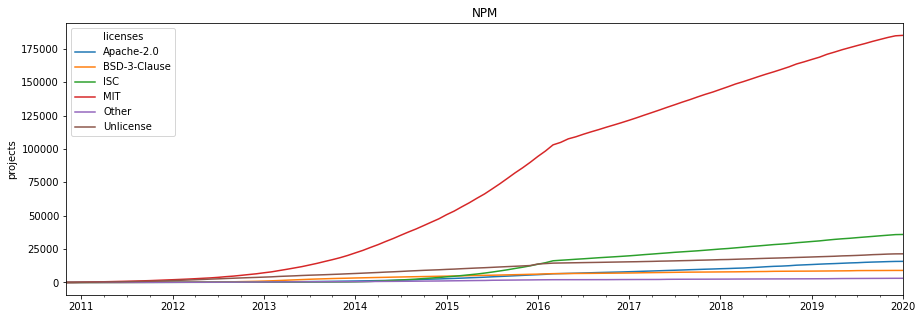

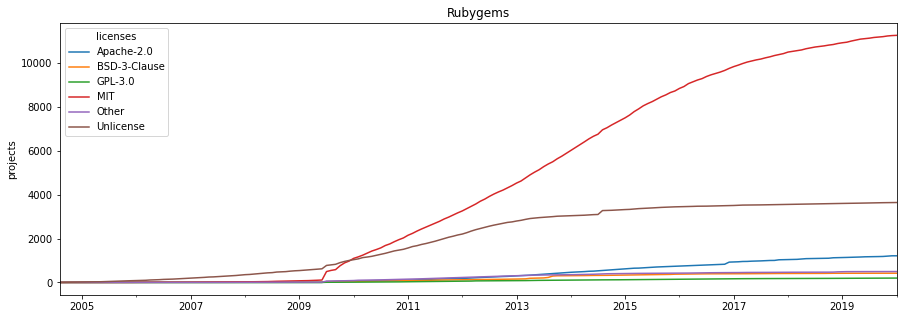

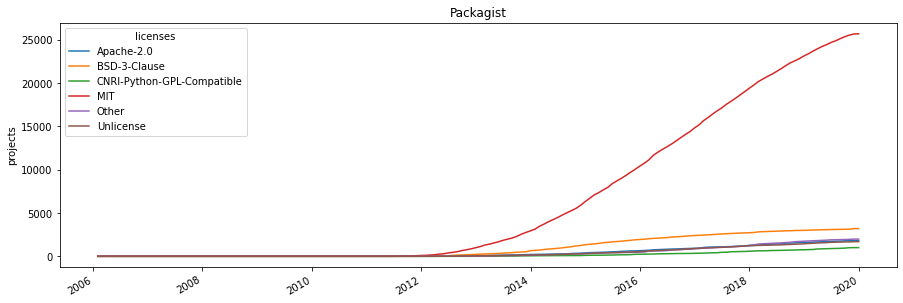

In [18]:
tmp=(packages
 .groupby(['platform','licenses','created'])
 .count()[['name']]
 .reset_index())

for platform in platforms:
    df_tmp = tmp.query('platform == "'+platform+'"')
    liste = df_tmp.groupby(['licenses'])['name'].sum().reset_index().sort_values('name').tail(6).licenses
    df_tmp = df_tmp[df_tmp.licenses.isin(liste)]
    df_tmp = (df_tmp.pivot(index='created', columns='licenses', values='name').fillna(0)
                   .reset_index().sort_values('created'))
    
    for c in df_tmp.columns[1:]:
        df_tmp[c] = df_tmp[c].cumsum()
    
    ax = df_tmp.plot(x='created',)
    ax.set_ylabel('projects')
    ax.set_xlabel('')
    ax.set_title(platform)
    ax.figure.set_size_inches(15,5)

# Researching levels of dependency trees

In [19]:
def print_amounts(df):
    total_dependencies = len(df)
    total_unknown_compatibility = len(df.query('compatible == "Unknown"'))
    total_compatible = len(df.query('compatible == True'))
    total_incompatible = len(df.query('compatible == False'))
    print(f'Could not determine compatibility for {total_unknown_compatibility} or {round(total_unknown_compatibility/total_dependencies*100, 2)}% of dependencies')
    print(f'{total_compatible} or {round(total_compatible/total_dependencies*100, 2)}% of dependencies are compatible')
    print(f'{total_incompatible} or {round(total_incompatible/total_dependencies*100, 2)}% of dependencies are not compatible')

In [20]:
packages["licenses"] = packages.licenses.astype('category')
packages["platform"] = packages.platform.astype('category')
packages["name"] = packages.name.astype('category')
packages = packages[packages.columns.difference(["created", "dependent_count"])]

levels_dfs = []

# Start with adding level 1
curr_level = 1
curr_level_df = (packages[packages.columns.difference(['licenses', 'first_release_date'])]
                 .merge(right=deps, on=['platform', 'name']))
curr_level_df = curr_level_df.merge(right=compatibility_df, on=["licenses", "dep_licenses"], how="left")
curr_level_df.compatible.fillna("Unknown", inplace=True)
curr_level_df["level"] = curr_level
levels_dfs.append(curr_level_df)
print("Level 1 done\n")

# Add levels 2 to 10
for i in range(2, 11):
    curr_level = i
    curr_level_df = curr_level_df.merge(right=deps, left_on=['dependency', 'platform'], right_on=['name', 'platform'])[['name_x', 'platform', 'licenses_x', 'dependency_y', 'dep_licenses_y']]
    curr_level_df.rename(inplace=True, columns={"name_x": "name", "licenses_x": "licenses", "dependency_y": "dependency", "dep_licenses_y": "dep_licenses"})
    curr_level_df.drop_duplicates(inplace=True)
    curr_level_df = curr_level_df.merge(right=compatibility_df, on=["licenses", "dep_licenses"], how="left")
    curr_level_df.compatible.fillna("Unknown", inplace=True)
    curr_level_df["compatible"] = curr_level_df.compatible.astype("category")
    curr_level_df["dependency"] = curr_level_df.dependency.astype('category')
    curr_level_df["name"] = curr_level_df.name.astype('category')
    curr_level_df["platform"] = curr_level_df.platform.astype("category")
    curr_level_df["licenses"] = curr_level_df.licenses.astype("category")
    curr_level_df["dep_licenses"] = curr_level_df.dep_licenses.astype("category")
    curr_level_df["level"] = curr_level
    levels_dfs.append(curr_level_df)
    print(f"Level {i} done\n")

levels_df = pd.concat(levels_dfs)


Level 1 done

Level 2 done

Level 3 done

Level 4 done

Level 5 done

Level 6 done

Level 7 done

Level 8 done

Level 9 done

Level 10 done



## Compatibility percentages on each level

In [21]:
for i in range(0, 10):
    print(f"Level {i+1}:")
    print_amounts(levels_dfs[i])

Level 1:
Could not determine compatibility for 39240 or 3.05% of dependencies
1077485 or 83.81% of dependencies are compatible
168963 or 13.14% of dependencies are not compatible
Level 2:
Could not determine compatibility for 207738 or 3.05% of dependencies
5570373 or 81.68% of dependencies are compatible
1041857 or 15.28% of dependencies are not compatible
Level 3:
Could not determine compatibility for 527866 or 3.01% of dependencies
14450684 or 82.47% of dependencies are compatible
2543516 or 14.52% of dependencies are not compatible
Level 4:
Could not determine compatibility for 936496 or 2.95% of dependencies
26394174 or 83.01% of dependencies are compatible
4466415 or 14.05% of dependencies are not compatible
Level 5:
Could not determine compatibility for 1393783 or 2.96% of dependencies
39192367 or 83.14% of dependencies are compatible
6551842 or 13.9% of dependencies are not compatible
Level 6:
Could not determine compatibility for 1920256 or 2.98% of dependencies
53564866 or 83

## Average dependency amount per level

Level 1
NPM: MIN = 0, Q1 = 0.0, MED = 2.0, MEAN = 3.938503000066242, Q3 = 4.0, MAX = 1122
Rubygems: MIN = 0, Q1 = 0.0, MED = 1.0, MEAN = 2.457347904093949, Q3 = 3.0, MAX = 222
Packagist: MIN = 0, Q1 = 0.0, MED = 1.0, MEAN = 2.773714771987786, Q3 = 3.0, MAX = 124


Level 2
NPM: MIN = 0, Q1 = 0.0, MED = 3.0, MEAN = 21.677481548110883, Q3 = 23.0, MAX = 3724
Rubygems: MIN = 0, Q1 = 0.0, MED = 2.0, MEAN = 8.474147773609525, Q3 = 11.0, MAX = 279
Packagist: MIN = 0, Q1 = 0.0, MED = 3.0, MEAN = 11.173249236622116, Q3 = 13.0, MAX = 216


Level 3
NPM: MIN = 0, Q1 = 0.0, MED = 4.0, MEAN = 57.76404592315228, Q3 = 58.0, MAX = 5754
Rubygems: MIN = 0, Q1 = 0.0, MED = 1.0, MEAN = 14.404447344098298, Q3 = 13.0, MAX = 445
Packagist: MIN = 0, Q1 = 0.0, MED = 2.0, MEAN = 17.24075186464434, Q3 = 19.0, MAX = 292


Level 4
NPM: MIN = 0, Q1 = 0.0, MED = 2.0, MEAN = 106.98686664783999, Q3 = 99.0, MAX = 7550
Rubygems: MIN = 0, Q1 = 0.0, MED = 0.0, MEAN = 17.84684390800848, Q3 = 12.0, MAX = 633
Packagist: MIN = 

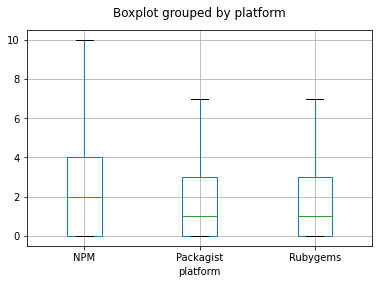

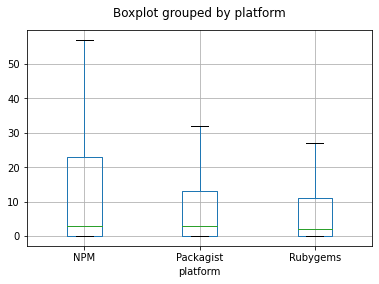

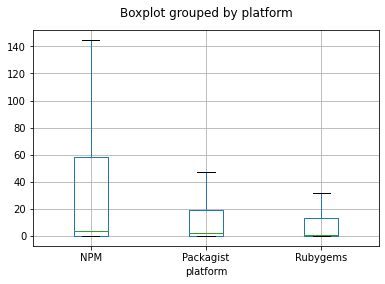

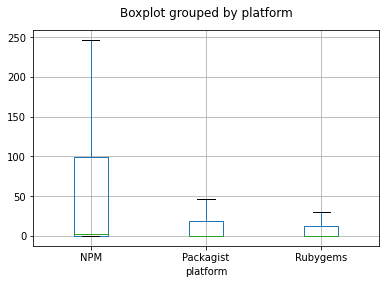

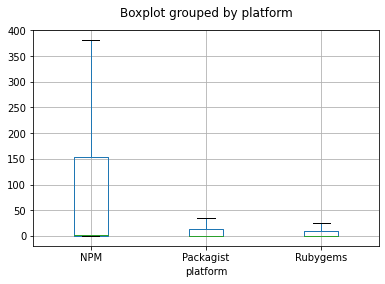

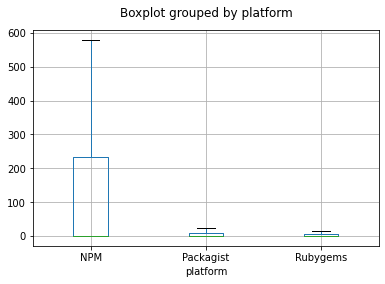

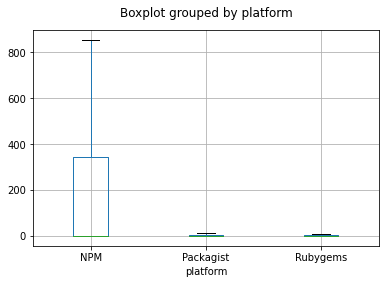

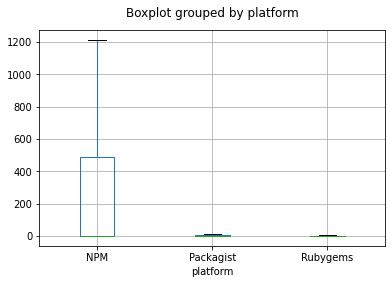

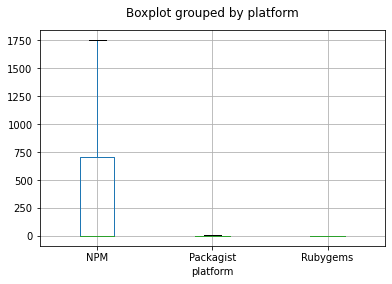

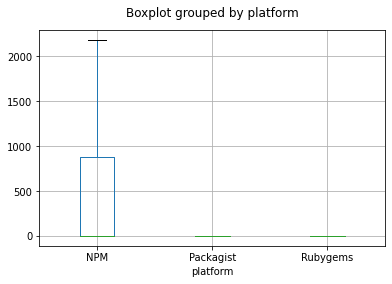

In [22]:
for i in range(0, 10):
    print(f"Level {i+1}")
    tmp = (levels_dfs[i]
           .groupby(['platform', 'name'])
           .size()
           .reset_index()
           .rename(columns={0:'dependency_count'})
           .merge(right=packages, how='right', on=["platform", "name"]))
    tmp["dependency_count"] = tmp.dependency_count.fillna(0).astype('uint16')
    boxplot = tmp.boxplot(column="dependency_count", by="platform", showfliers=False)
    boxplot.set_title('')
    for platform in platforms:
        ptmp = tmp.query(f'platform == "{platform}"')
        print(f'{platform}: MIN = {ptmp.dependency_count.min()}, Q1 = {ptmp.dependency_count.quantile([0.25])[0.25]}, MED = {ptmp.dependency_count.median()}, MEAN = {ptmp.dependency_count.mean()}, Q3 = {ptmp.dependency_count.quantile([0.75])[0.75]}, MAX = {ptmp.dependency_count.max()}')
    print("\n")

### Most common license pairs in each ecosystem
Format = derrivative's license + used package's license

In [23]:
occ_df = []

for i in range(0, 4):
    print(f"Level {i+1}")
    tmp = (levels_dfs[i]
           .groupby(['platform', 'licenses', 'dep_licenses'])
           .size()
           .reset_index()
           .rename(columns={0:'count'}))
    tmp['level'] = i+1
    for platform in platforms:
        df_tmp = tmp.query('platform == "'+platform+'"').sort_values(by='count', ascending=False).head(10)
        occ_df.append(df_tmp)
    
occ_df = pd.concat(occ_df)

# TOP 10 license pairs over all levels
top_pairs = occ_df.groupby(['platform', 'licenses', 'dep_licenses'])["count"].agg('sum').reset_index().sort_values(by='count', ascending=False)
top_pairs['pairname'] = top_pairs['licenses'].astype(str)+" + "+top_pairs['dep_licenses'].astype(str)


# TOP 10 license pairs for each level
top_pairs_for_levels = occ_df.groupby(['level', 'platform', 'licenses', 'dep_licenses'])["count"].agg('sum').reset_index().sort_values(by='count', ascending=False)
top_pairs_for_levels['pairname'] = top_pairs_for_levels['licenses'].astype(str)+" + "+top_pairs_for_levels['dep_licenses'].astype(str)


Level 1
Level 2
Level 3
Level 4


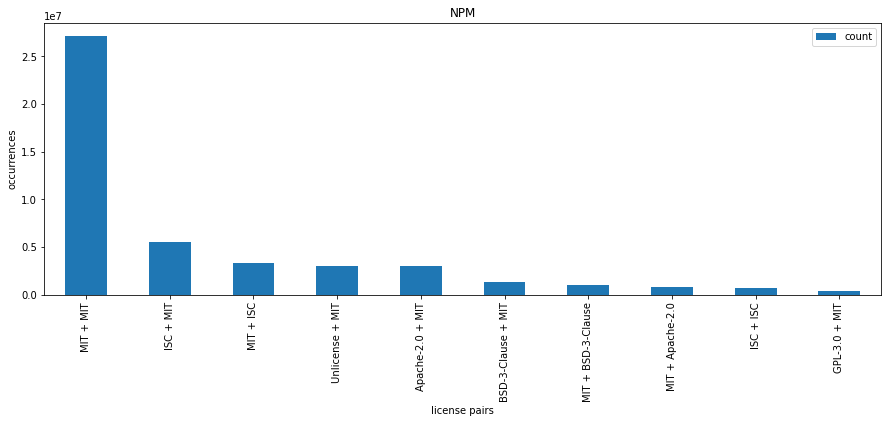

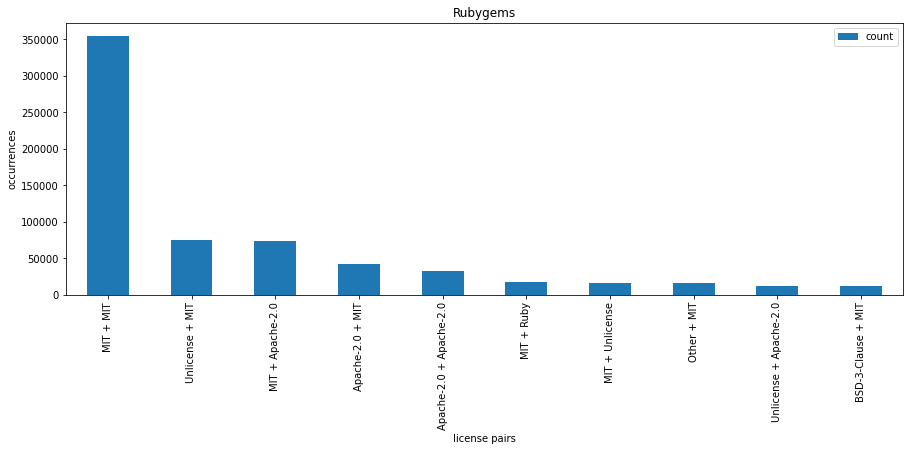

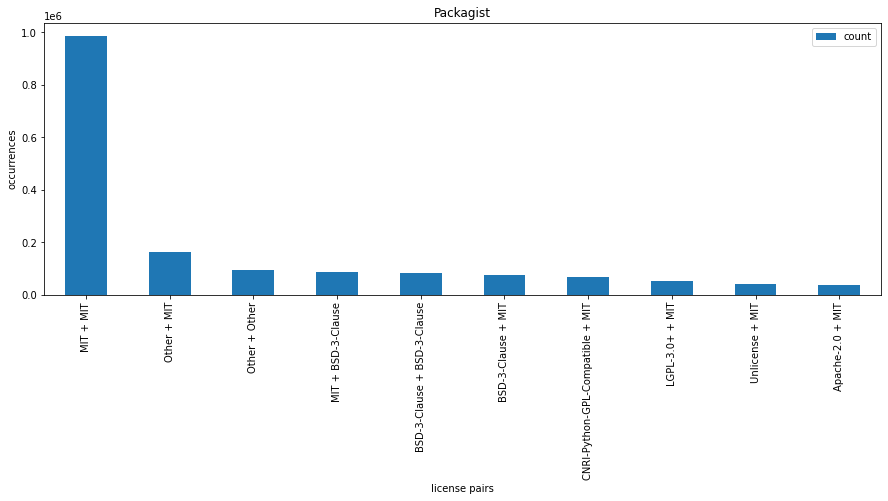

In [24]:
# TOP PAIRS OVER ALL LEVELS
for platform in platforms:
    df_tmp = top_pairs.query('platform == "'+platform+'"').head(10)
    chart = df_tmp.plot.bar(x='pairname', y='count')
    chart.set_ylabel('occurrences')
    chart.set_xlabel('license pairs')
    chart.set_title(platform)
    chart.figure.set_size_inches(15,5)

In [25]:
tmp = levels_df.groupby(['level', 'platform', 'licenses', 'dep_licenses']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)
tmp["pairname"] = tmp["licenses"] + " + " + tmp["dep_licenses"]

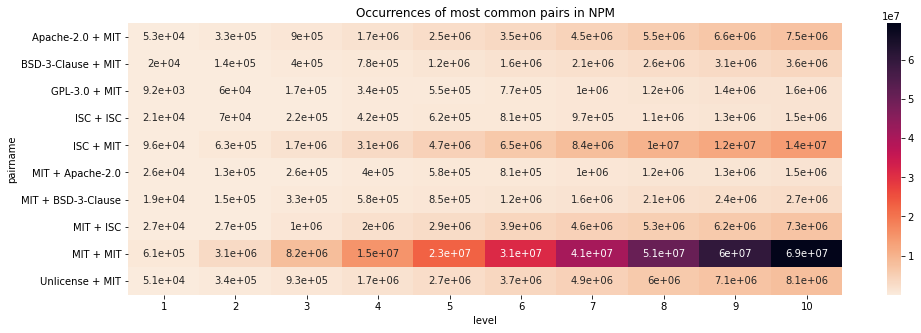

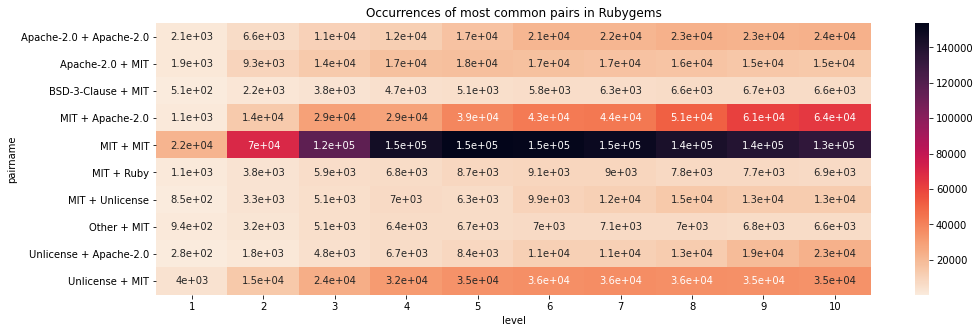

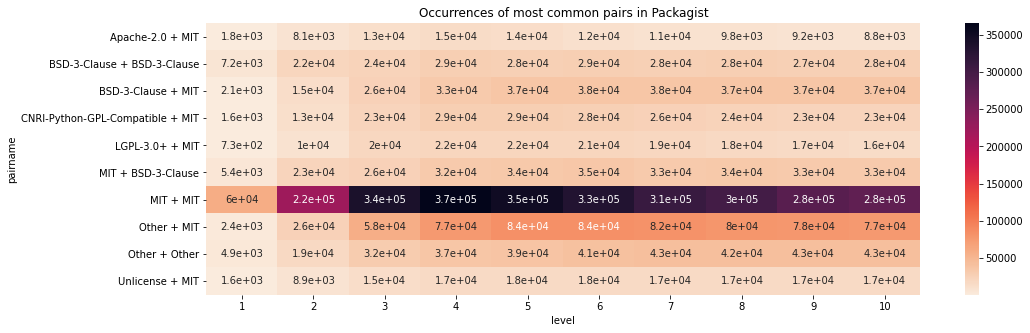

In [26]:
for platform in platforms:
    plt.figure(figsize = (16,5))
    ax = sns.heatmap(tmp.query(f'platform == "{platform}"')[tmp.query(f'platform == "{platform}"').pairname.isin(top_pairs.query(f'platform == "{platform}"').head(10).pairname)].pivot(index='pairname', columns='level', values='count').fillna(0), annot=True, cmap=sns.cm.rocket_r)
    ax.set_title(f'Occurrences of most common pairs in {platform}')
    plt.show()

### Most common illegal license pairs in each ecosystem
Format = derrivative's license + used package's license

In [27]:
occ_df = []

for i in range(0, 4):
    print(f"Level {i+1}")
    tmp = (levels_dfs[i]
           .query('compatible == False')
           .groupby(['platform', 'licenses', 'dep_licenses'])
           .size()
           .reset_index()
           .rename(columns={0:'count'}))
    tmp['level'] = i+1
    for platform in platforms:
        df_tmp = tmp.query('platform == "'+platform+'"').sort_values(by='count', ascending=False).head(10)
        occ_df.append(df_tmp)
    
occ_df = pd.concat(occ_df)

# TOP 10 license pairs over all levels
illegal_top_pairs = occ_df.groupby(['platform', 'licenses', 'dep_licenses'])["count"].agg('sum').reset_index().sort_values(by='count', ascending=False)
illegal_top_pairs['pairname'] = illegal_top_pairs['licenses'].astype(str)+" + "+illegal_top_pairs['dep_licenses'].astype(str)


# TOP 10 license pairs for each level
illegal_top_pairs_for_levels = occ_df.groupby(['level', 'platform', 'licenses', 'dep_licenses'])["count"].agg('sum').reset_index().sort_values(by='count', ascending=False)
illegal_top_pairs_for_levels['pairname'] = illegal_top_pairs_for_levels['licenses'].astype(str)+" + "+illegal_top_pairs_for_levels['dep_licenses'].astype(str)


Level 1
Level 2
Level 3
Level 4


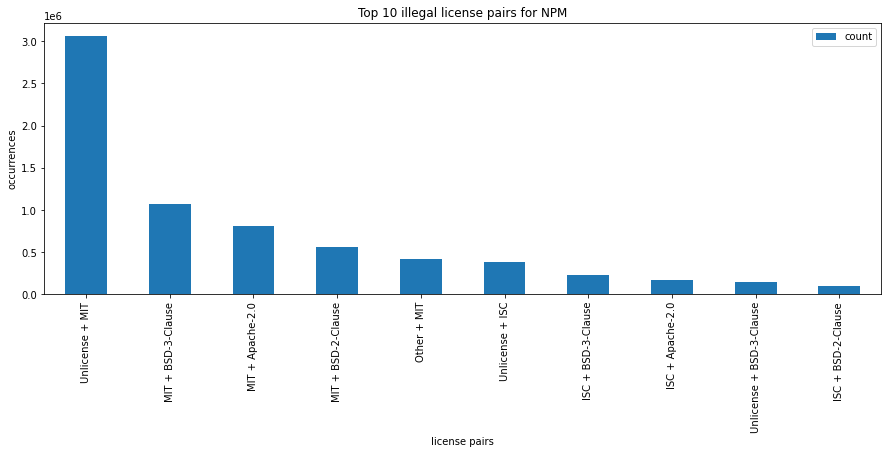

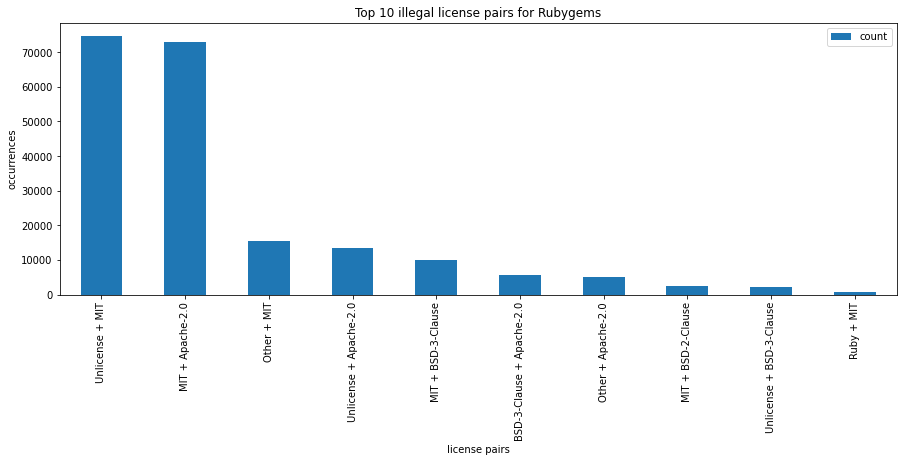

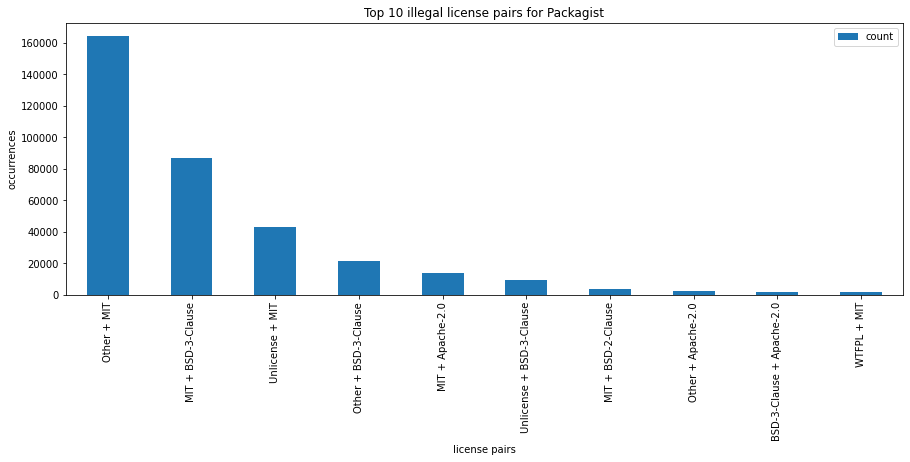

In [28]:
# TOP ILLEGAL PAIRS OVER ALL LEVELS
for platform in platforms:
    df_tmp = illegal_top_pairs.query('platform == "'+platform+'"').head(10)
    chart = df_tmp.plot.bar(x='pairname', y='count')
    chart.set_ylabel('occurrences')
    chart.set_xlabel('license pairs')
    chart.set_title(f'Top 10 illegal license pairs for {platform}')
    chart.figure.set_size_inches(15,5)

In [29]:
tmp = levels_df.query('compatible == False').groupby(['level', 'platform', 'licenses', 'dep_licenses']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)
tmp["pairname"] = tmp["licenses"] + " + " + tmp["dep_licenses"]


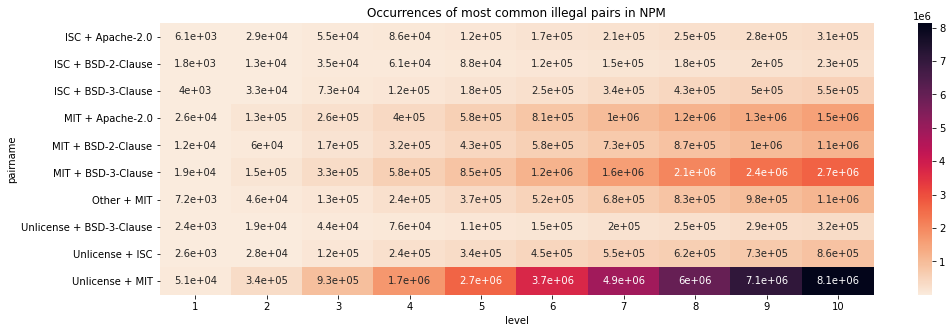

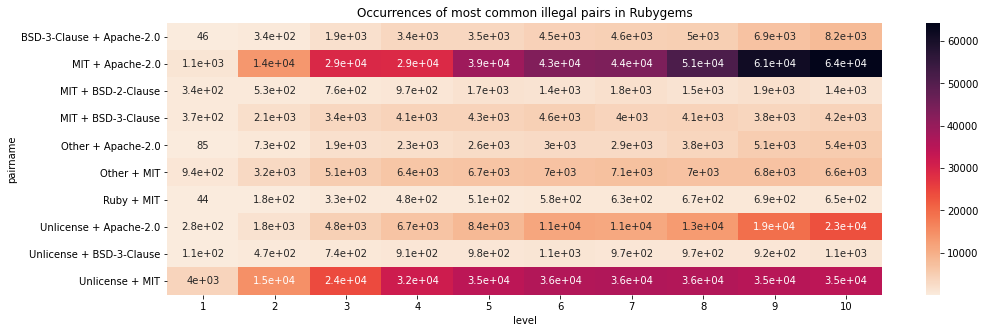

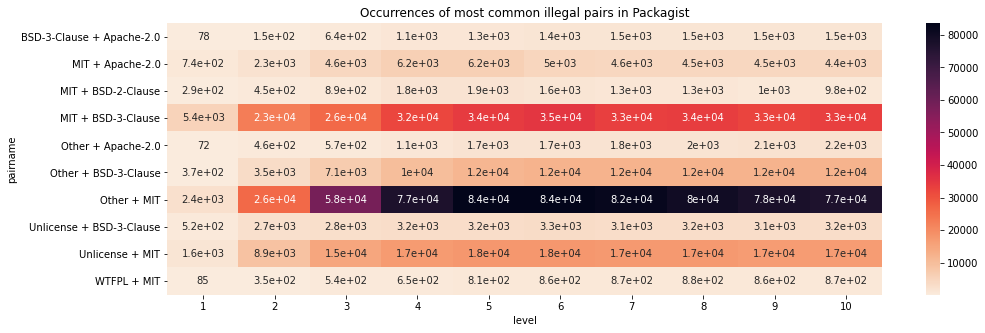

In [30]:
for platform in platforms:
    plt.figure(figsize = (16,5))
    ax = sns.heatmap(tmp.query(f'platform == "{platform}"')[tmp.query(f'platform == "{platform}"').pairname.isin(illegal_top_pairs.query(f'platform == "{platform}"').head(10).pairname)].pivot(index='pairname', columns='level', values='count').fillna(0), annot=True, cmap=sns.cm.rocket_r)
    ax.set_title(f'Occurrences of most common illegal pairs in {platform}')
    plt.show()

### Ecosystems with the most issues

platform
NPM          148673
Packagist     12573
Rubygems       7994
dtype: int64

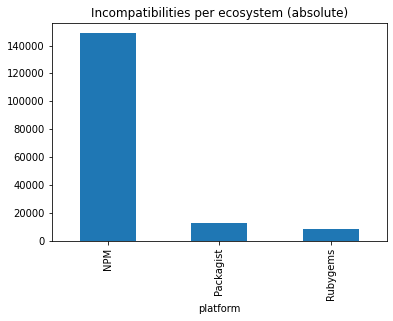

In [21]:
test = curr_level_df.query('compatible == False').groupby('platform').size()
test.plot.bar(title="Incompatibilities per ecosystem (absolute)")
test

platform
NPM          13.160758
Packagist    11.345323
Rubygems     17.686623
dtype: float64

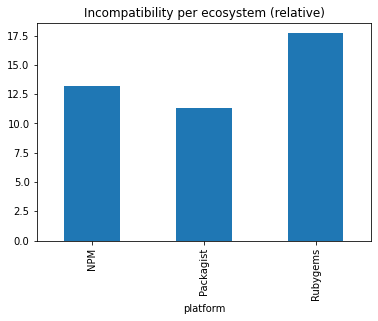

In [22]:
test = curr_level_df.query('compatible == False').groupby('platform').size().astype(float)
test["NPM"] = 100*test["NPM"]/curr_amount_of_npm_deps
test["Packagist"] = 100*test["Packagist"]/curr_amount_of_packagist_deps
test["Rubygems"] = 100*test["Rubygems"]/curr_amount_of_rubygems_deps
test.plot.bar(title="Incompatibility per ecosystem (relative)")
test

### Average amount of compatible/incompatible/unknown dependencies per package at this level

In [23]:
count_comp_types = curr_level_df.groupby(by=["platform", "name", "compatible"]).size().reset_index().rename(columns={0:'occ'})
count_comp_types = packages[["platform", "name"]].merge(right=count_comp_types, how="left", on=["platform", "name"])
count_comp_types.groupby(["platform", "compatible"]).occ.mean()

platform   compatible
NPM        False         2.409025
           True          5.150627
           Unknown       2.242259
Packagist  False         2.137538
           True          3.574014
           Unknown       3.052948
Rubygems   False         2.119862
           True          3.184923
           Unknown       1.567308
Name: occ, dtype: float64

# Some license pairs that have unknown compatibility

In [19]:
tmp = (levels_df.query('level == 1').groupby(['platform', 'compatible', 'licenses', 'dep_licenses'])
       .size()
       .reset_index()
       .rename(columns={0:'count'})
       .sort_values(by='count', ascending=False))

tmp['pairname'] = tmp['licenses']+"+"+tmp['dep_licenses']

for platform in platforms:
    df_tmp = tmp.query('platform == "'+platform+'" & compatible == "Unknown"').head(10)
    chart = df_tmp.plot.bar(x='pairname', y='count')
    chart.set_ylabel('occurrences')
    chart.set_xlabel('license pairs')
    chart.set_title(platform)
    chart.figure.set_size_inches(15,5)

MemoryError: 